In [23]:
from math import pi
import numpy as np
import scipy
import math
import random
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, assemble, Aer
from qiskit.primitives import Estimator
from qiskit.circuit import Gate
from math import pi
from qiskit.circuit import ParameterVector, Parameter
from qiskit_algorithms import VQE, NumPyEigensolver
from qiskit_algorithms.optimizers import *
from qiskit_algorithms.utils import *
import qiskit.quantum_info as qi
import numpy as np
from qiskit.quantum_info import SparsePauliOp

import time

#from qiskit import execute
#from qiskit.visualization import array_to_latex
#from qiskit.opflow import I, X, Z
#from qiskit.quantum_info import Statevector
#from qiskit.quantum_info.operators import Operator


import qiskit.tools.jupyter
%qiskit_version_table

In [24]:
qubits=8
J=0

In [25]:
#-----------FUNCTIONS--------------
def lam(α,β,x): #α,β=x,y,z ; x[0]->Tau ; x[1]->Theta ; x[2]->Phi // x has 3 components
    out=0
    if(α==0 and β==0):
        out=np.sin(x[0]/2.0)*np.sin(x[0]/2.0)*(2*np.sin(x[1])*np.sin(x[1])*np.cos(x[2])*np.cos(x[2])-1)+np.cos(x[0]/2.0)*np.cos(x[0]/2.0)
    if(α==0 and β==1):
        out=2*np.sin(x[0]/2.0)*(np.sin(x[0]/2.0)*np.sin(x[1])*np.sin(x[1])*np.sin(x[2])*np.cos(x[2])-np.cos(x[0]/2.0)*np.cos(x[1]))
    if(α==0 and β==2):
        out=2*np.sin(x[0]/2.0)*np.sin(x[1])*(np.sin(x[0]/2.0)*np.cos(x[1])*np.cos(x[2])+np.cos(x[0]/2.0)*np.sin(x[2]))
    if(α==1 and β==0):
        out=2*np.sin(x[0]/2.0)*(np.sin(x[0]/2.0)*np.sin(x[1])*np.sin(x[1])*np.sin(x[2])*np.cos(x[2])+np.cos(x[0]/2.0)*np.cos(x[1]))
    if(α==1 and β==1):
        out=np.sin(x[0]/2.0)*np.sin(x[0]/2.0)*(2*np.sin(x[1])*np.sin(x[1])*np.sin(x[2])*np.sin(x[2])-1)+np.cos(x[0]/2.0)*np.cos(x[0]/2.0)
    if(α==1 and β==2):
        out=2*np.sin(x[0]/2.0)*np.sin(x[1])*(np.sin(x[0]/2.0)*np.cos(x[1])*np.sin(x[2])-np.cos(x[0]/2.0)*np.cos(x[2]))
    if(α==2 and β==0):
        out=2*np.sin(x[0]/2.0)*np.sin(x[1])*(np.sin(x[0]/2.0)*np.cos(x[1])*np.cos(x[2])-np.cos(x[0]/2.0)*np.sin(x[2]))
    if(α==2 and β==1):
        out=2*np.sin(x[0]/2.0)*np.sin(x[1])*(np.sin(x[0]/2.0)*np.cos(x[1])*np.sin(x[2])+np.cos(x[0]/2.0)*np.cos(x[2]))
    if(α==2 and β==2):
        out=np.sin(x[0]/2.0)*np.sin(x[0]/2.0)*(2*np.cos(x[1])*np.cos(x[1])-1)+np.cos(x[0]/2.0)*np.cos(x[0]/2.0)
    return(out)

def X(n, x, y, M): #n->qubit, x & y & M -> parameters
    E_X=0
    s=1
    for i in range(0,qubits):
        if(i!=n):
            s*=(-1j*np.sin(M[n][i]/2.0)*lam(2,2,x[i])+np.cos(M[n][i]/2.0)) #IMPORTANT: IS IT A 2 OR 4??????
    
    E_X+=np.real(s)*(lam(0,0,y[n])*lam(0,2,x[n])+lam(0,1,y[n])*lam(1,2,x[n]))
    E_X+=np.imag(s)*(lam(0,0,y[n])*lam(1,2,x[n])-lam(0,1,y[n])*lam(0,2,x[n]))
    E_X+=lam(0,2,y[n])*lam(2,2,x[n])
    return(E_X)

def Y(n, x, y, M): #n->qubit, x & y & M -> parameters
    E_Y=0
    s=1
    for i in range(0,qubits):
        if(i!=n):
            s*=(-1j*np.sin(M[n][i]/2.0)*lam(2,2,x[i])+np.cos(M[n][i]/2.0)) #IMPORTANT: IS IT A 2 OR 4??????
    
    E_Y+=np.real(s)*(lam(1,0,y[n])*lam(0,2,x[n])+lam(1,1,y[n])*lam(1,2,x[n]))
    E_Y+=np.imag(s)*(lam(1,0,y[n])*lam(1,2,x[n])-lam(1,1,y[n])*lam(0,2,x[n]))
    E_Y+=lam(1,2,y[n])*lam(2,2,x[n])
    return(E_Y)

def Z(n, x, y, M): #n->qubit, x & y & M -> parameters
    E_Z=0
    s=1
    for i in range(0,qubits):
        if(i!=n):
            s*=(-1j*np.sin(M[n][i]/2.0)*lam(2,2,x[i])+np.cos(M[n][i]/2.0)) #IMPORTANT: IS IT A 2 OR 4??????
    
    E_Z+=np.real(s)*(lam(2,0,y[n])*lam(0,2,x[n])+lam(2,1,y[n])*lam(1,2,x[n]))
    E_Z+=np.imag(s)*(lam(2,0,y[n])*lam(1,2,x[n])-lam(2,1,y[n])*lam(0,2,x[n]))
    E_Z+=lam(2,2,y[n])*lam(2,2,x[n])
    return(E_Z)

def ZZ(n, m, x, y, M): #n & m ->qubit, x & y & M -> parameters
    E_ZZ=0
    z=1
    v=1
    p=1
    t=1
    for i in range(0,qubits): #IMPORTANT: IS IT A 2 OR 4??????
        if(i!=n and i!=m):
            z*=(+1j*np.sin((M[n][i]+M[m][i])/2.0)*lam(2,2,x[i])+np.cos((M[n][i]+M[m][i])/2.0))
            v*=(+1j*np.sin((M[n][i]-M[m][i])/2.0)*lam(2,2,x[i])+np.cos((M[n][i]-M[m][i])/2.0))
            p*=(1j*np.sin(M[n][i]/2.0)*lam(2,2,x[i])+np.cos(M[n][i]/2.0))
            t*=(1j*np.sin(M[m][i]/2.0)*lam(2,2,x[i])+np.cos(M[m][i]/2.0))
    p*=(1j*np.sin(M[n][m]/2.0)+np.cos(M[n][m]/2.0)*lam(2,2,x[m]))
    t*=(1j*np.sin(M[m][n]/2.0)+np.cos(M[m][n]/2.0)*lam(2,2,x[n]))
    
    E_ZZ+=(np.real(z)/2.0)*(lam(2,0,y[n])*lam(2,0,y[m])*(lam(0,2,x[n])*lam(0,2,x[m])-lam(1,2,x[n])*lam(1,2,x[m]))+
                           lam(2,0,y[n])*lam(2,1,y[m])*(lam(1,2,x[n])*lam(0,2,x[m])+lam(0,2,x[n])*lam(1,2,x[m]))+
                           lam(2,1,y[n])*lam(2,0,y[m])*(lam(1,2,x[n])*lam(0,2,x[m])+lam(0,2,x[n])*lam(1,2,x[m]))-
                           lam(2,1,y[n])*lam(2,1,y[m])*(lam(0,2,x[n])*lam(0,2,x[m])-lam(1,2,x[n])*lam(1,2,x[m]))
                          )
    E_ZZ+=(np.imag(z)/2.0)*(-lam(2,0,y[n])*lam(2,0,y[m])*(lam(1,2,x[n])*lam(0,2,x[m])+lam(0,2,x[n])*lam(1,2,x[m]))+
                            lam(2,0,y[n])*lam(2,1,y[m])*(lam(0,2,x[n])*lam(0,2,x[m])-lam(1,2,x[n])*lam(1,2,x[m]))+
                            lam(2,1,y[n])*lam(2,0,y[m])*(lam(0,2,x[n])*lam(0,2,x[m])-lam(1,2,x[n])*lam(1,2,x[m]))+
                            lam(2,1,y[n])*lam(2,1,y[m])*(lam(1,2,x[n])*lam(0,2,x[m])+lam(0,2,x[n])*lam(1,2,x[m]))
                          )
    E_ZZ+=(np.real(v)/2.0)*(lam(2,0,y[n])*lam(2,0,y[m])*(lam(0,2,x[n])*lam(0,2,x[m])+lam(1,2,x[n])*lam(1,2,x[m]))-
                           lam(2,0,y[n])*lam(2,1,y[m])*(lam(1,2,x[n])*lam(0,2,x[m])-lam(0,2,x[n])*lam(1,2,x[m]))+
                           lam(2,1,y[n])*lam(2,0,y[m])*(lam(1,2,x[n])*lam(0,2,x[m])-lam(0,2,x[n])*lam(1,2,x[m]))+
                           lam(2,1,y[n])*lam(2,1,y[m])*(lam(0,2,x[n])*lam(0,2,x[m])+lam(1,2,x[n])*lam(1,2,x[m]))
                          )
    E_ZZ+=(np.imag(v)/2.0)*(-lam(2,0,y[n])*lam(2,0,y[m])*(lam(1,2,x[n])*lam(0,2,x[m])-lam(0,2,x[n])*lam(1,2,x[m]))-
                            lam(2,0,y[n])*lam(2,1,y[m])*(lam(0,2,x[n])*lam(0,2,x[m])+lam(1,2,x[n])*lam(1,2,x[m]))+
                            lam(2,1,y[n])*lam(2,0,y[m])*(lam(0,2,x[n])*lam(0,2,x[m])+lam(1,2,x[n])*lam(1,2,x[m]))-
                            lam(2,1,y[n])*lam(2,1,y[m])*(lam(1,2,x[n])*lam(0,2,x[m])-lam(0,2,x[n])*lam(1,2,x[m]))
                          )
    E_ZZ+=np.real(p)*(lam(2,0,y[n])*lam(2,2,y[m])*lam(0,2,x[n])+
                      lam(2,1,y[n])*lam(2,2,y[m])*lam(1,2,x[n])
                     )
    E_ZZ+=np.imag(p)*(-lam(2,0,y[n])*lam(2,2,y[m])*lam(1,2,x[n])+
                       lam(2,1,y[n])*lam(2,2,y[m])*lam(0,2,x[n])
                     )
    E_ZZ+=np.real(t)*(lam(2,2,y[n])*lam(2,0,y[m])*lam(0,2,x[m])+
                      lam(2,2,y[n])*lam(2,1,y[m])*lam(1,2,x[m])
                     )
    E_ZZ+=np.imag(t)*(-lam(2,2,y[n])*lam(2,0,y[m])*lam(1,2,x[m])+
                       lam(2,2,y[n])*lam(2,1,y[m])*lam(0,2,x[m])
                     )
    E_ZZ+=lam(2,2,y[n])*lam(2,2,y[m])*lam(2,2,x[n])*lam(2,2,x[m])
    return(E_ZZ) 

In [26]:
#--------------HAMILTONIAN----------------------
def LRH_cl(t, J, eps, h, alpha): 
    #Parameters of Ansatze
    x=np.zeros((qubits,3))
    y=np.zeros((qubits,3))
    M=np.zeros((qubits,qubits))
    for i in range(0,qubits):
        x[i]=t[0+3*i:3+3*i]
        y[i]=t[3*qubits+0+3*i:3*qubits+3+3*i]
    p=6*qubits
    for i in range(0,qubits-1):
        k=0
        for j in range(i+1,qubits):
            M[i][j]=t[k+p]
            M[j][i]=t[k+p]
            k+=1
        p+=k    
        
    b=1 #This is fixed b=1
    J_bar=0
    N_bar=1
    J_ham=0
    dist=0
    for j in range (1,qubits):
        dist = min(abs(j), qubits - abs(j))
        N_bar+=float(1/dist)**alpha #Normalization    
    E=0
    for i in range(0,qubits):
        for j in range(0,qubits):
            if(i==j):
                J_bar=J*b
                J_ham=float(J_bar/N_bar)
                E+=J_ham
            else:
                dist=min(abs(i - j), qubits - abs(i - j))
                J_bar=J*dist**(-alpha)
                J_ham=float(J_bar/N_bar)
                E+=J_ham*ZZ(i,j,x,y,M)
    for i in range(0,qubits):
        E+=h*X(i,x,y,M)
        E+=eps*Z(i,x,y,M)
    return (E)  

def LRH_Matrix(J, eps, h, alpha): #Capital Letters correspond to inputs (Intensity of the Fields)
    b=1 #This is fixed b=1
    J_bar=0
    N_bar=1
    J_ham=0
    dist=0
    for j in range (1,qubits):
        dist = min(abs(j), qubits - abs(j))
        N_bar+=float(1/dist)**alpha #Normalization
        
    ZZ_tuples=[]
    for i in range(0,qubits):
        for j in range(0,qubits):
            if(i==j):
                J_bar=J*b
                J_ham=float(J_bar/N_bar)
                ZZ_tuples.append(('I', [i], J_ham)) #ZZ in the same qubit is the identity
            else:
                dist=min(abs(i - j), qubits - abs(i - j))
                J_bar=J*(dist**(-alpha))
                J_ham=float(J_bar/N_bar)
                ZZ_tuples.append(('ZZ', [i,j], J_ham)) #Coupling      
                         
    X_tuples = [('X', [i], h) for i in range(0, qubits)] #Uniform Transverse Field
    Z_tuples = [('Z', [i], eps) for i in range(0, qubits)] #Longitudinal Field

    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *X_tuples, *Z_tuples], num_qubits = qubits)
    return hamiltonian.simplify()

#----------- PARAMETERS (THETA)-------------
initialθ=[np.random.uniform(0,np.pi), np.random.uniform(0,np.pi), np.random.uniform(0,2*np.pi),
          np.random.uniform(0,np.pi), np.random.uniform(0,np.pi), np.random.uniform(0,2*np.pi)]*qubits
dimM=int(qubits*(qubits-1)/2)
initialM=[np.random.uniform(-2*np.pi,2*np.pi)]*dimM

initialParam=initialθ+initialM
starting_point=[0]*len(initialParam)

boundsθ=[[0, np.pi], [0, np.pi], [0, 2*np.pi],
         [0, np.pi], [0, np.pi], [0, 2*np.pi]]*qubits
boundsM=[[0,2*np.pi]]*dimM
bounds=boundsθ+boundsM

n_steps=2000
min_iterations=1
inter_param=[]
inter_fun=[]
def save_step(k):
    inter_param.append(k)
    inter_fun.append(LRH_cl(k, J, eps, h, alpha))
    if len(inter_fun)<min_iterations:
        return False  # Continue optimization process
    else:
        return True  # Terminate optimization process
    
counts_L1=[]
values_L1=[]
param_L1=[]

def store_intermediate_result_L1(eval_count, parameters, mean, std):
    counts_L1.append(eval_count)
    values_L1.append(mean)
    param_L1.append(parameters)
    
counts_L2=[]
values_L2=[]
param_L2=[]

def store_intermediate_result_L2(eval_count, parameters, mean, std):
    counts_L2.append(eval_count)
    values_L2.append(mean)
    param_L2.append(parameters)

In [27]:
class U_xyz_Gate(Gate):
    def __init__(
        self,
        tau,
        theta,
        phi,
        q,
        label=None,
        *,
        duration=None,
        unit="dt",
        
    ):
        super().__init__('U', 1, [tau,theta,phi], label=label)

    
    def _define(self):
        qc = QuantumCircuit(2)
        qc.unitary(self.to_matrix(), [self.q])
        self.definition = qc
    
    def __array__(self, dtype=complex):
        """Return a numpy.array for the U_xyz gate."""
        tau, theta, phi = (float(param) for param in self.params)
        
        return np.array([[np.cos(tau/2)-1j*np.sin(tau/2)*np.cos(theta), -1j*np.sin(tau/2)*np.sin(theta)*np.exp(-1j*phi) ], 
                         [ -1j*np.sin(tau/2)*np.sin(theta)*np.exp(1j*phi) , np.cos(tau/2)+1j*np.sin(tau/2)*np.cos(theta)]]
                         , dtype=dtype)

def GsCircuit(layers, t): #Nº of parameters needed is 6N+N(N-1)/2
    qc = QuantumCircuit(qubits)
    dimM_layer=int(qubits*(qubits-1)/2)
    dimθ_layer=6*qubits
    dim_layer=dimM_layer+dimθ_layer
    for layer in range (0, layers, 1):
        #---------- This is U(x)
        for i in range (0,qubits):
            U_x = U_xyz_Gate(t[0+3*i+dim_layer*layer],t[0+3*i+1+dim_layer*layer],t[0+3*i+2+dim_layer*layer],i,label='U_xyz')
            qc.append(U_x, [i])
        #---------- This is V(M)
        p=6*qubits
        for i in range(0,qubits-1):
            k=0
            for j in range(i+1,qubits):
                qc.cx(i,j)
                qc.rz(t[k+p+dim_layer*layer]/2.0,j)
                qc.cx(i,j)
                k+=1
            p+=k 
        #---------- This is U(y)
        for i in range (0,qubits):
            U_y = U_xyz_Gate(t[3*qubits+0+3*i+dim_layer*layer],t[3*qubits+0+3*i+1+dim_layer*layer],t[3*qubits+0+3*i+2+dim_layer*layer],i,label='U_xyz')
            qc.append(U_y, [i])
        qc.barrier()
    return qc

def InitializeParameters (layers): 
    dimM=int(qubits*(qubits-1)/2)*layers
    dimθ=6*qubits*layers
    s=qubits*layers
    dimt=dimM+dimθ
    
    initialθ=[0]*dimθ
    initialM=[0]*dimM
    initialParam=[0]*dimt
    
    initialθ=[np.random.uniform(0,np.pi), np.random.uniform(0,np.pi), np.random.uniform(0,2*np.pi),
              np.random.uniform(0,np.pi), np.random.uniform(0,np.pi), np.random.uniform(0,2*np.pi)]*s
    initialM=[np.random.uniform(-2*np.pi,2*np.pi)]*dimM
    initialParam=initialθ+initialM
    
    return (initialParam)

def GroundStatesL1(layers, J, h, eps, alpha, qcircuit):
    
    #iterations = 300 #Maybe quitar esta condición al usar COBYLA?
    seed=170
    algorithm_globals.random_seed=seed

    estimator=Estimator()
    ansatz=qcircuit
    optimizer=SLSQP()

    initialθ=InitializeParameters (layers)
    
    Hami=LRH_Matrix(J, eps, h, alpha) #H is intensity of longitudinal field. Hami is hamiltonian
    vqe=VQE(estimator, ansatz, optimizer, initial_point=initialParam, callback=store_intermediate_result_L1)
    result=vqe.compute_minimum_eigenvalue(Hami)

    return result.optimal_value
    #Function returns the VQE groundstate and the exact minimum and maximum
    
def GroundStatesL2(layers, J, h, eps, alpha, qcircuit):
    
    #iterations = 300 #Maybe quitar esta condición al usar COBYLA?
    seed=170
    algorithm_globals.random_seed=seed

    estimator=Estimator()
    ansatz=qcircuit
    optimizer=SLSQP()

    initialθ=InitializeParameters (layers)
    
    Hami=LRH_Matrix(J, eps, h, alpha) #H is intensity of longitudinal field. Hami is hamiltonian
    vqe=VQE(estimator, ansatz, optimizer, initial_point=initialParam, callback=store_intermediate_result_L2)
    result=vqe.compute_minimum_eigenvalue(Hami)

    return result.optimal_value
    #Function returns the VQE groundstate and the exact minimum and maximum

In [28]:
#------- PARAMATERS OF THE SIMULATION----------
eps=0.001 #Break degeneracy
h=-1 #h is transverse field, not hamiltonian.
alpha=2.5
#Store values
E_L1=0
E_L2=0
E_cl=0
ED1=0
ED2=0

In [29]:
#----------VQE LAYER 1-----------
layers=1

for i in range(0,1):
    dimM=int(qubits*(qubits-1)/2)*layers
    dimθ=6*qubits*layers
    dimt=dimM+dimθ
    initialParam=InitializeParameters(layers)
    starting_point=[0]*len(initialParam)
    t=ParameterVector('θ', length=dimt)
    qc=GsCircuit(layers, t)

    start = time.time()    

    Hami=LRH_Matrix(J, eps, h, alpha)
    ED=NumPyEigensolver(k = qubits).compute_eigenvalues(Hami).eigenvalues
    result_sim=GroundStatesL1(layers, J, h, eps, alpha, qc)

    err_rel=0
    result_exact=ED[0]
    err_rel=abs((result_sim-result_exact)*100/result_exact)
    
    ED1=result_exact
    E_L1=result_sim
    ED2=ED[1]
    print('--------- VALOR DE J:'+str(J))
    print('El valor VQA es:')
    print(result_sim)
    print('El valor ED es:')
    print(result_exact)
    print('El error relativo es:')
    print(err_rel)
    end = time.time()
    print(f"El codigo con ha tardado: {end-start} seconds, usando layers: "+str(layers))
    #STORE STEPS
    Step_L1=[0]*len(values_L1)
    Step_L1=values_L1

--------- VALOR DE J:0
El valor VQA es:
-8.00000288437963
El valor ED es:
-8.000003999998968
El error relativo es:
1.3945234766528325e-05
El codigo con ha tardado: 35.450010538101196 seconds, usando layers: 1


In [30]:
for i in range(0,1):

    #-------CLASSICAL-------
    initialθ=[np.random.uniform(0,np.pi), np.random.uniform(0,np.pi), np.random.uniform(0,2*np.pi),
                np.random.uniform(0,np.pi), np.random.uniform(0,np.pi), np.random.uniform(0,2*np.pi)]*qubits
    dimM=int(qubits*(qubits-1)/2)
    initialM=[np.random.uniform(-2*np.pi,2*np.pi)]*dimM

    initialParam=initialθ+initialM
    starting_point=[0]*len(initialParam)

    boundsθ=[[0, np.pi], [0, np.pi], [0, 2*np.pi],
             [0, np.pi], [0, np.pi], [0, 2*np.pi]]*qubits
    boundsM=[[0,2*np.pi]]*dimM
    bounds=boundsθ+boundsM
    #-----MIDDLE POINT------
    start = time.time() 
    Hami=LRH_Matrix(J, eps, h, alpha)
    ED=NumPyEigensolver(k = qubits).compute_eigenvalues(Hami).eigenvalues
    E_cl=scipy.optimize.minimize(LRH_cl, initialParam, args=(J, eps, h, alpha),
                                     callback=save_step, 
                                     bounds = bounds,
                                     method = 'SLSQP')
    err_rel=0
    result_exact=ED[0]
    err_rel=abs((E_cl.fun-result_exact)*100/result_exact)
    E_cl=E_cl.fun
    print('--------- VALOR DE J:'+str(J))
    print('El valor clasico es:')
    print(E_cl)
    print('El valor ED es:')
    print(result_exact)
    print('El error relativo es:')
    print(err_rel)
    
    end = time.time()
    print(f"El codigo ha tardado: {end-start} seconds, usando clásico")
    #STORE STEPS
    Step_cl=[0]*len(inter_fun)
    Step_cl=inter_fun

--------- VALOR DE J:0
El valor clasico es:
-8.000002349144479
El valor ED es:
-8.000003999998958
El error relativo es:
2.0635670668370298e-05
El codigo ha tardado: 90.58332324028015 seconds, usando clásico


In [31]:
for i in range (0,1):
    #----------VQE LAYER 2------
    layers=2
    
    dimM=int(qubits*(qubits-1)/2)*layers
    dimθ=6*qubits*layers
    dimt=dimM+dimθ
    initialParam=InitializeParameters (layers)
    t=ParameterVector('θ', length=dimt)
    qc=GsCircuit(layers, t)

    #-----MIDDLE POINT------
    start = time.time() 
    result_sim=GroundStatesL2(layers, J, h, eps, alpha, qc)

    err_rel=0
    result_exact=ED[0]
    err_rel=abs((result_sim-result_exact)*100/result_exact)
    

    E_L2=result_sim
    print('--------- VALOR DE J:'+str(J))
    print('El valor VQA es:')
    print(result_sim)
    print('El valor ED es:')
    print(result_exact)
    print('El error relativo es:')
    print(err_rel)
    
    end = time.time()
    print(f"El codigo ha tardado: {end-start} seconds, usando layers: "+str(layers))
    #STORE STEPS
    Step_L2=[0]*len(values_L2)
    Step_L2=values_L2

--------- VALOR DE J:0
El valor VQA es:
-7.99997734555635
El valor ED es:
-8.000003999998958
El error relativo es:
0.0003331803660066489
El codigo ha tardado: 192.30923986434937 seconds, usando layers: 2


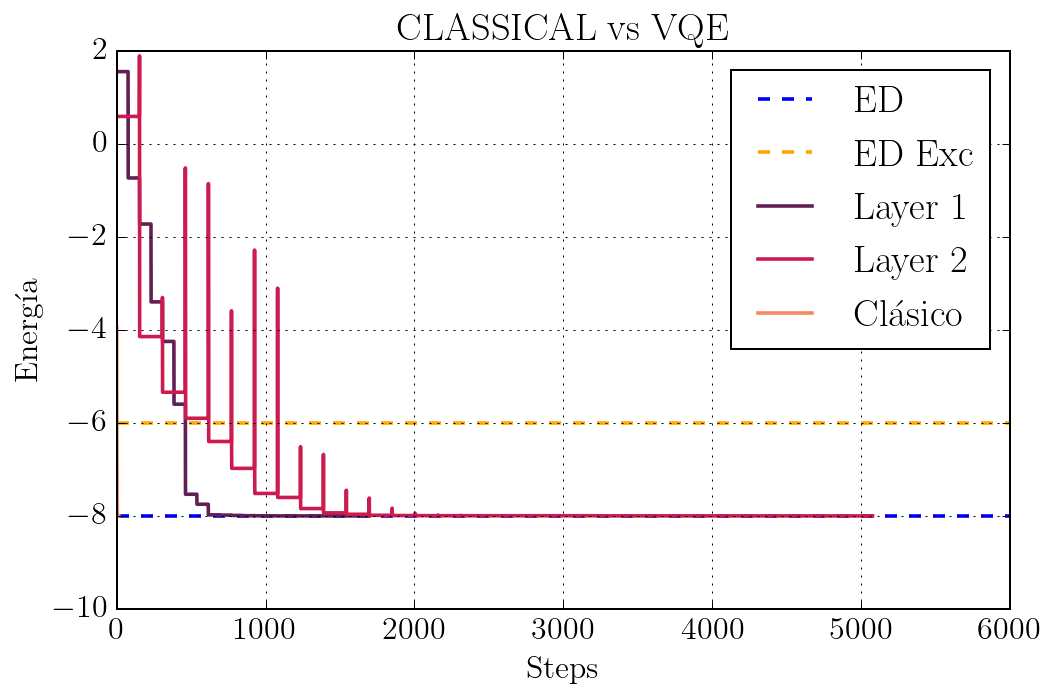

In [32]:
#QUANTUM VS CLASSICAL: ENERGY EVOLUTION
from mpl_toolkits.axes_grid1 import make_axes_locatable
%config InlineBackend.figure_format = 'retina'
plt.style.use('classic')
%matplotlib inline
import matplotlib as mpl
import seaborn as sns

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['lines.linewidth'] = 1.8
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['figure.facecolor'] = 'white'

colors = sns.color_palette("rocket", 3)

plt.axhline(ED1, color='b', linestyle='--', label='ED')
plt.axhline(ED2, color='orange', linestyle='--', label='ED Exc')

plt.plot(Step_L1, marker='', linestyle='-', color=colors[0], label='Layer 1')
plt.plot(Step_L2, marker='', linestyle='-', color=colors[1], label='Layer 2')
plt.plot(Step_cl, marker='', linestyle='-', color=colors[2], label='Clásico')

plt.xlabel('Steps')
plt.ylabel('Energía')
plt.title('CLASSICAL vs VQE')
plt.grid(True)
plt.legend()
plt.show()

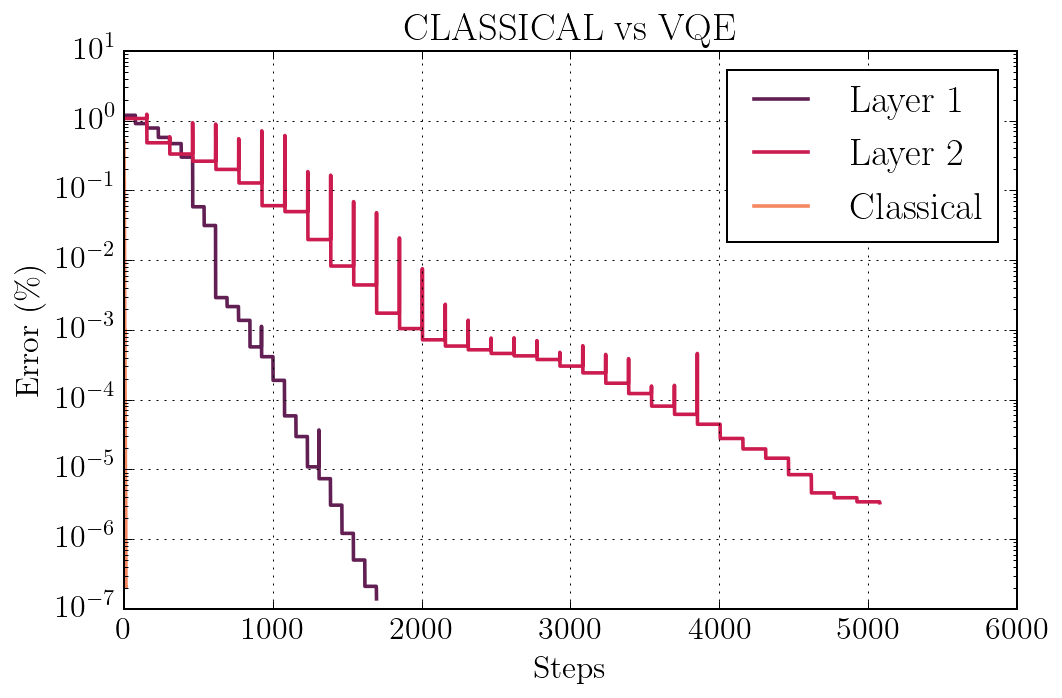

In [33]:
#QUANTUM VS CLASSICAL: ERROR EVOLUTION
Error_L1=[0]*len(Step_L1)
Error_L2=[0]*len(Step_L2)
Error_cl=[0]*len(Step_cl)
for i in range(len(Step_L1)):
    Error_L1[i]=abs((Step_L1[i]-ED1)/ED1)
for i in range(len(Step_L2)):
    Error_L2[i]=abs((Step_L2[i]-ED1)/ED1)
for i in range(len(Step_cl)):
    Error_cl[i]=abs((Step_cl[i]-ED1)/ED1)
        
colors = sns.color_palette("rocket", 3)

plt.plot(Error_L1, marker='', linestyle='-', color=colors[0], label='Layer 1')
plt.plot(Error_L2, marker='', linestyle='-', color=colors[1], label='Layer 2')
plt.plot(Error_cl, marker='', linestyle='-', color=colors[2], label='Classical')

plt.xlabel('Steps')
plt.ylabel('Error (\%)')
plt.yscale('log')
plt.title('CLASSICAL vs VQE')
plt.grid(True)
plt.legend()
plt.show()

In [34]:
#QUANTUM VS CLASSICAL: ENERGY EVOLUTION
Error_QM=[0]*len(values_L1)
for i in range(len(Error_QM)):
    Error_QM[i]=abs(values_L1[i]-LRH_cl(param_L1[i], J, eps, h, alpha))

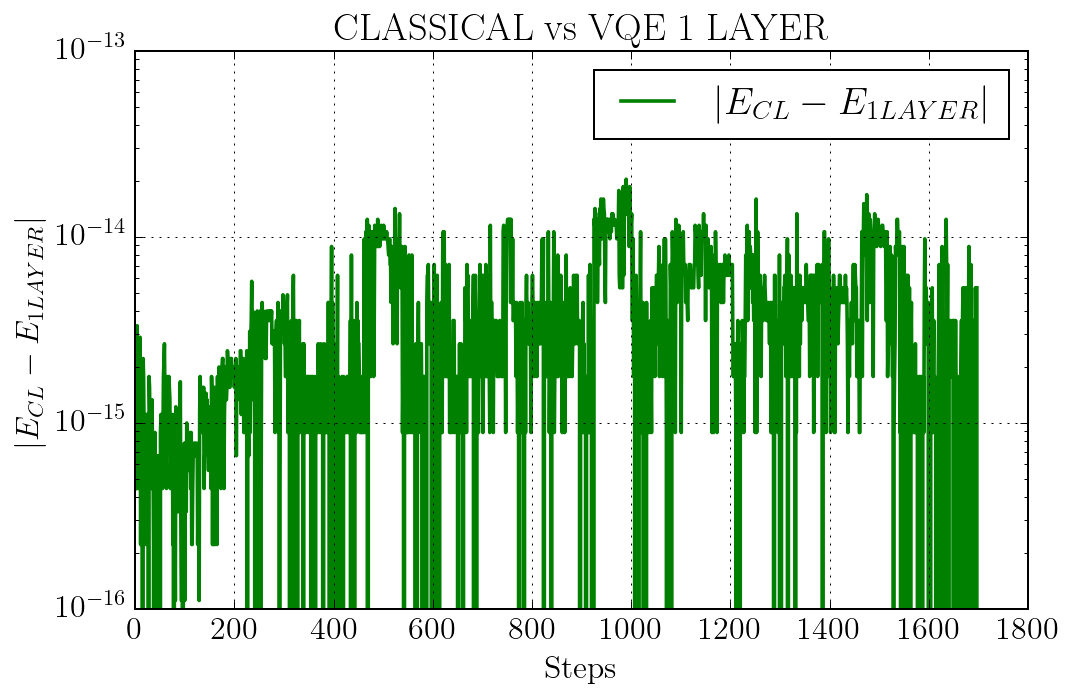

In [35]:
plt.plot(Error_QM, marker='', linestyle='-', color='g', label='$|E_{CL}-E_{1 LAYER}|$')

plt.xlabel('Steps')
plt.ylabel('$|E_{CL}-E_{1 LAYER}|$')
plt.yscale('log')
plt.title('CLASSICAL vs VQE 1 LAYER')
plt.grid(True)
plt.legend()
plt.show()

In [36]:
file_1=open('C:\\Users\\lucas\\OneDrive\\Escritorio\\Universidad\\TFG\\Codigos\\SLSQP\\STEPS_Qubits='+str(qubits)+'_Alpha='+str(alpha)+'\\L1_V6.txt','w')
file_2=open('C:\\Users\\lucas\\OneDrive\\Escritorio\\Universidad\\TFG\\Codigos\\SLSQP\\STEPS_Qubits='+str(qubits)+'_Alpha='+str(alpha)+'\\L2_V6.txt','w')
file_3=open('C:\\Users\\lucas\\OneDrive\\Escritorio\\Universidad\\TFG\\Codigos\\SLSQP\\STEPS_Qubits='+str(qubits)+'_Alpha='+str(alpha)+'\\Cl_V6.txt','w')

file_1.write('#E_L1 en funcion de Steps\n') #CONTENTS OF FILE_1
file_2.write('#E_L2 en funcion de Steps\n') #CONTENTS OF FILE_2
file_3.write('#E_cl en funcion de Steps\n') #CONTENTS OF FILE_3

for i in range(len(Step_L1)):
    file_1.write(str(Step_L1[i])+'\n') 
for i in range(len(Step_L2)):
    file_2.write(str(Step_L2[i])+'\n') 
for i in range(len(Step_cl)):
    file_3.write(str(Step_cl[i])+'\n') 

file_1.close()
file_2.close()
file_3.close()

In [37]:
file=open('C:\\Users\\lucas\\OneDrive\\Escritorio\\Universidad\\TFG\\Codigos\\COBYLA\\CLASSICAL_1LAYER\\DATA_V6.txt','w')

file.write('#|E_Cl - E_L1| en funcion de Steps\n') #CONTENTS OF FILE_1

for i in range(len(Error_QM)):
    file.write(str(Error_QM[i])+'\n') 

file.close()